Import parish boundaries

In [1]:
import geopandas
from shapely.geometry import Point

df_parishes = geopandas.read_file("../data/lisbon_parishes.geojson")

Import language mapping

In [2]:
import pandas as pd
df_language = pd.read_csv("../data/parish_data_quarterly.csv")

Pull the points of interest and categorize them

In [15]:
from pyrosm import OSM

osm = OSM("../data/lisbon-latest.osm.pbf")

pois = osm.get_pois()
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

In [36]:
categories = sorted([value for value in pois["poi_type"].unique().tolist() if value is not None])
languages = df_language["language"].unique().tolist()

def encode(rows):
    value_counts = rows["poi_type"].value_counts()
    return [
        value_counts.get(category, 0) for category in categories
    ]

encodings = []
mode_languages = []

for _, parish in df_parishes.iterrows():
    language_mode = df_language[df_language["parish_id"] == parish.id]["language"].mode()
    if len(language_mode) > 0:
        filtered_pois = pois[pois["geometry"].within(parish.geometry)]
        encodings.append(encode(filtered_pois))
        mode_languages.append(languages.index(language_mode.iloc[0]))

In [43]:
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

X = np.array(encodings)
y = np.array(mode_languages)

reg = linear_model.LogisticRegression()
scores = cross_val_score(reg, X, y, cv=5, scoring="accuracy")

[0.57692308 0.61538462 0.76       0.84       0.6       ]
0.6784615384615384


/Users/fohlen/PycharmProjects/airbnb_lisbon_analysis/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/fohlen/PycharmProjects/airbnb_lisbon_analysis/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fohlen/PycharmProjects/airbnb_lisbon_analysis/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF IT

In [44]:
print(len(categories))

390


In [45]:
print(len(languages))

13


In [46]:
print(scores)
print(np.mean(scores))
print(np.std(scores))

[0.57692308 0.61538462 0.76       0.84       0.6       ]
0.6784615384615384
0.10313890214703021


In [53]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_pca_elbow(X, max_components=None):
    """
    Plots the explained variance ratio as a function of the number of principal components.

    Args:
        X (numpy.ndarray): The input data matrix.
        max_components (int, optional): The maximum number of components to consider. If None,
                                        it defaults to the number of features in X.
    """

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    n_components = min(X_scaled.shape) if max_components is None else min(max_components, X_scaled.shape[1])

    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_components + 1), cumulative_variance_ratio, marker='o', linestyle='--')
    plt.title('PCA Elbow Plot')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.grid(True)
    plt.savefig("elbow_plot.png")
    plt.show()

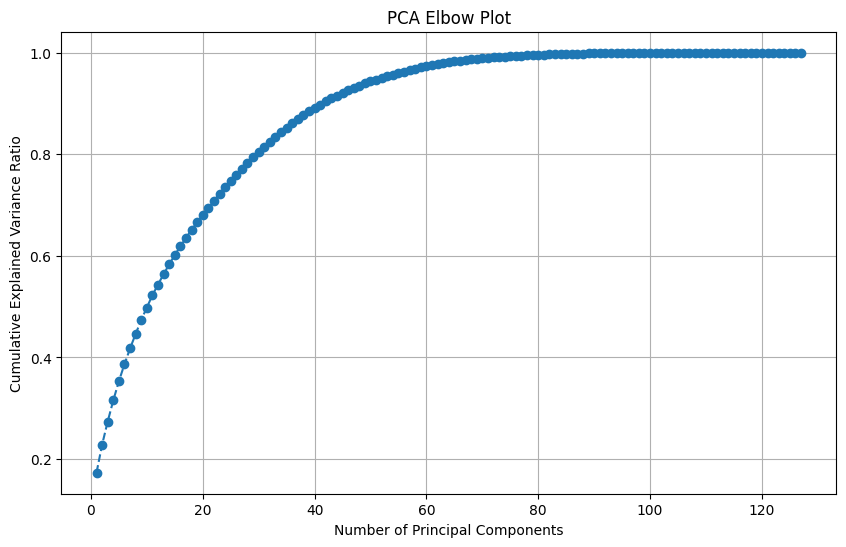

In [54]:
plot_pca_elbow(X)
